In [ ]:
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Dependencies

In [ ]:
import torch
import dgl
from collections import namedtuple
import dgl.function as fn
from copy import deepcopy as dc
import random
import time
from time import time
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import copy


## Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Agent

In [ ]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 2         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 1       # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, env, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        node_state = state[: -1 ]
        valid_action = []
        for i in range(len(node_state)):
            if(node_state[i] == 0 and env.cost[i] <= env.max_budget):
                valid_action.append(True)
            else:
                valid_action.append(False)

        valid_action_arg = []
        for i in range(len(valid_action)):
            if valid_action[i] == True:
                valid_action_arg.append(i)


        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        mn = -1e9
        for i in range(len(valid_action)):
            if(valid_action[i] == False):
                action_values[0][i] = mn

        # Epsilon-greedy action selection
        if random.random() > eps:
            # picks action with maximum value attached to it 
            choice = np.argmax(action_values.cpu().data.numpy())
            if choice == mn : 
                return -1

            return choice
        else:
            # randomly pick any action from the values that are not already chosen 
            # return random.choice(np.arange(self.action_size))
            if len(valid_action_arg) == 0 :
                return -1
                
            choice = random.choice(valid_action_arg)
            return choice

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Environment

In [ ]:
import torch
import dgl
from collections import namedtuple
import dgl.function as fn
from copy import deepcopy as dc
import random
import time
from time import time
from torch.utils.data import DataLoader
import numpy as np
from collections import deque

class IM(object):
    def __init__(self, max_budget, p, num_nodes, cost):
        self.max_budget = max_budget
        self.BUDGET = max_budget
        assert(p <= 1 and p >= 0)
        self.p = p
        self.num_nodes = num_nodes
        self.cost = cost

    def compute_reward(self, state):
        # reward is the number of additional nodes influenced
        reward = 0
        # each node has one chance to influence each neighbour
        new_influenced = state.detach().cpu().numpy().ravel()
        tot_influenced = state.detach().cpu().numpy().ravel()
        while((new_influenced == 1).sum() >= 1):
            # next = torch.full(
            #     (self.num_nodes, 1),
            #     0, 
            #     dtype = torch.long
            #     )
            next = np.zeros(self.num_nodes)
            for e in range(self.g.number_of_edges()):
                if((new_influenced[self.g.edges()[0][e]] == 1) and 
                   not(tot_influenced[self.g.edges()[1][e]] == 1 or new_influenced[self.g.edges()[1][e]] == 1)):
                    r = random.random()
                    if(r < self.p):
                        # node influenced
                        next[self.g.edges()[1][e]] = 1
                        reward += 1
            tot_influenced = tot_influenced + new_influenced
            new_influenced = next
        return reward
     
    def step(self, action):
        reward, sol, done = self._take_action(action)
        
        ob = self._build_ob()
        self.sol = sol
        info = {"sol": self.sol}

        # need to convert ob to ndarray from tensor
        ob = ob.detach().cpu().numpy().ravel()
        next_state = np.copy(ob)
        return next_state, reward, done, info
    
    def _take_action(self, action):
        r1, r2 = 0, 0
        num_iter = 250
        for i in range(num_iter):
            r1 += self.compute_reward(self.x[:-1])
        if(self.x[action] == 0 and self.cost[action] <= self.max_budget):
            self.x[action] = 1
            self.x[-1] -= self.cost[action]
            self.max_budget -= self.cost[action]
        # write code for else case 
        next_sol = 0
        for i in range(num_iter):
            r2 += self.compute_reward(self.x[:-1])
        done = self._check_done()
        return (r2 - r1)/num_iter, next_sol, done

    def _check_done(self): 
        inactive = (self.x[:-1] == 0).type(torch.float)
        self.g.ndata['h'] = inactive
        not_selected = dgl.sum_nodes(self.g, 'h')
        self.g.ndata.pop('h')
        done = (not_selected == 0) or (self.max_budget <= 0)
        return done
                
    def _build_ob(self):
        ob_x = self.x
        # ob = torch.cat([ob_x], dim = 2)
        # return ob
        return ob_x
    
    # using num_samples = 1 as of now 
    def register(self, g, num_samples = 1):
        self.g = g
        self.g.set_n_initializer(dgl.init.zero_initializer)
        t = torch.full((self.num_nodes, 1), 0, dtype=torch.float16)
        # torch.full(
            #     (self.num_nodes, 1),
            #     0, 
            #     dtype = torch.long
            #     )
        self.x = torch.cat((t, torch.tensor([[self.max_budget]])), 0)
        ob = self._build_ob()
        return ob


    def reset(self):
        state = np.zeros(self.num_nodes + 1)
        state[-1] = self.BUDGET

        t = torch.full((self.num_nodes, 1), 0, dtype=torch.float16)
        self.max_budget = self.BUDGET
        self.x = torch.cat((t, torch.tensor([[self.max_budget]])), 0)

        return np.array(state)

## Main 

In [ ]:

# cost = torch.tensor([300, 300, 300, 300, 300, 300, 300])
# maxb = 1500

# src_ids = torch.tensor([0, 1, 2, 3])
# dst_ids = torch.tensor([1, 2, 3, 4])

# n_nodes = 5
# n_edges = 4

# p = 0.6 

# env = IM(maxb, p , n_nodes, cost)
# g = dgl.rand_graph(n_nodes, n_edges)
# # g = dgl.graph((src_ids, dst_ids), num_nodes=5)

# print(g.edges()[0])
# ob = env.register(g)

# env_greedy = copy.deepcopy(env)

# print(ob)
# # obnext, reward, done, info = env.step(3)
# # print(obnext, reward, done, info)
# # obnext, reward, done, info = env.step(3)
# # print(obnext, reward, done, info)
# # obnext, reward, done, info = env.step(3)
# # print(obnext, reward, done, info)


### dqn

In [ ]:
def dqn(env, agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(env, state, eps)
            if action == -1:
                break 
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    return scores

# scores = dqn(50)

### greedy

In [ ]:
def greedy(env_greedy, agent, n_episodes=2000):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores

    for i_episode in range(1, n_episodes+1):
        score = 0
        mn = -1e9
        env = copy.deepcopy(env_greedy)
        n = env.num_nodes

        while True:
            reward_per_cost = np.full(n, mn)

            done = False
            for i in range(n):
                temp = copy.deepcopy(env)
                if env.x[i] == 0 and env.cost[i] <= env.max_budget :
                    _, reward, _, _ = temp.step(i)
                    reward_per_cost[i] = reward / temp.cost[i]
                
            choice = np.argmax(reward_per_cost)
            if reward_per_cost[choice] == mn:
                break

            _, reward, done, _ = env.step(choice)
            score += reward

            if done == True:
                break
            
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
            
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    return scores


# scores2 = greedy(50)

## Plots

In [ ]:
def plt_scores(scores1, scores2, n):
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores1)), scores1, 'b', label = 'dqn \n' + str(round(np.average(scores1), 4)))
    # plt.plot(np.unique(np.arange(len(scores1))), np.poly1d(np.polyfit(np.arange(len(scores1)), scores1, 1))(np.unique(np.arange(len(scores1)))) , '--b')
    plt.plot(np.arange(len(scores2)), scores2, '--c', label = 'greedy \n ' + str(round(np.average(scores2), 4)))
    # plt.plot(np.unique(np.arange(len(scores2))), np.poly1d(np.polyfit(np.arange(len(scores2)), scores2, 1))(np.unique(np.arange(len(scores2)))) , '--c')

    plt.ylabel('Score')
    plt.xlabel('Episode #')
    leg = plt.legend(frameon = False)
    plt.tight_layout()
    plt.savefig('score' + str(n) + '.png')


def plt_graph(g, cost, title, n):
    G = dgl.to_networkx(g)
    fig = plt.figure()
    ax = fig.add_subplot()
    labeldict = {}
    for i in range(n_nodes):
        labeldict[i] = (i, cost[i].item())
    nx.draw(G, labels = labeldict, pos=nx.spring_layout(G), with_labels = True)

    font_dict = {'horizontalalignment': 'left'}
    ax.set_title(title, font_dict)

    plt.tight_layout()
    plt.savefig('g' + str(n) + '.png')

number of nodes:  5
number of edges:  8
nodes:  [0 1 2 3 4]
edges:  (tensor([0, 4, 2, 0, 3, 0, 1, 1]), tensor([1, 3, 3, 3, 0, 2, 4, 1]))
p: 0.33105716196700286
cost:  [1287 1321 1407 1010 1441]
max budget:  7500



/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Episode 10	Average Score: 0.07
Episode 20	Average Score: 0.01
Episode 30	Average Score: 0.02
Episode 40	Average Score: 0.07
Episode 50	Average Score: 0.05
Episode 10	Average Score: 0.01
Episode 20	Average Score: -0.00
Episode 30	Average Score: -0.00
Episode 40	Average Score: 0.00
Episode 50	Average Score: 0.01

------------------------------------------------------
number of nodes:  6
number of edges:  9
nodes:  [0 1 2 3 4 5]
edges:  (tensor([4, 1, 2, 3, 2, 5, 3, 3, 4]), tensor([3, 4, 4, 1, 3, 3, 3, 4, 0]))
p: 0.1308610881057347
cost:  [1405 1087 1093 1114 1200 1091]
max budget:  9000

Episode 10	Average Score: 0.04
Episode 20	Average Score: 0.04
Episode 30	Average Score: 0.02
Episode 40	Average Score: 0.01
Episode 50	Average Score: 0.00
Episode 10	Average Score: 0.03
Episode 20	Average Score: -0.03
Episode 30	Average Score: -0.01
Episode 40	Average Score: 0.00
Episode 50	Average Score: 0.01

------------------------------------------------------
number of nodes:  7
number of edges:  1

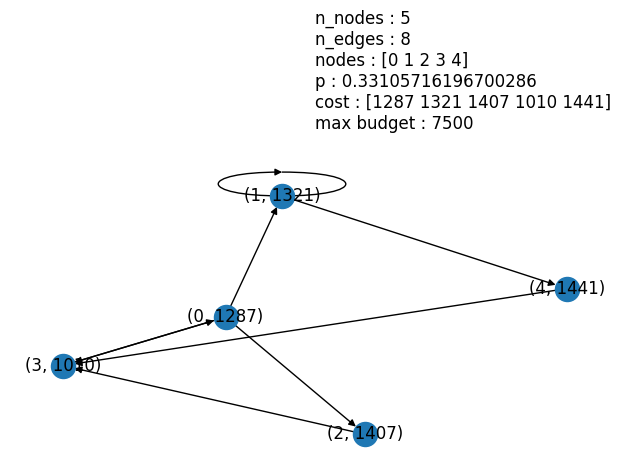

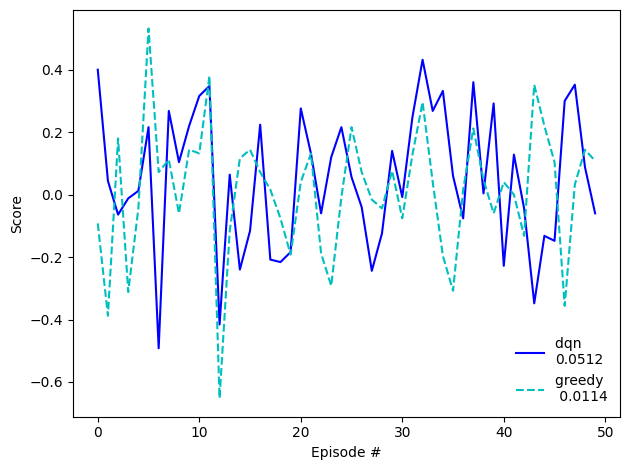

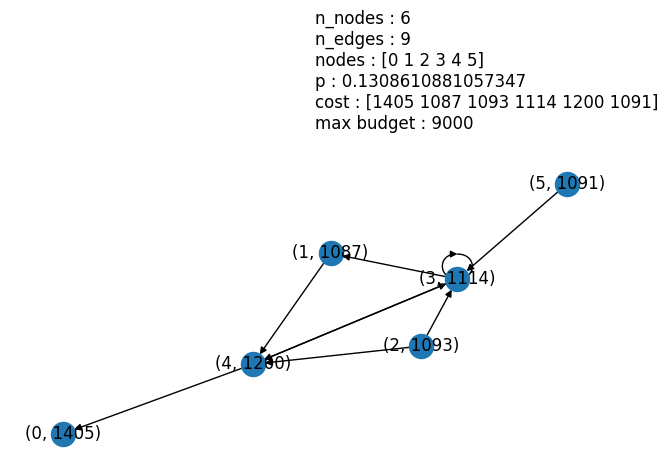

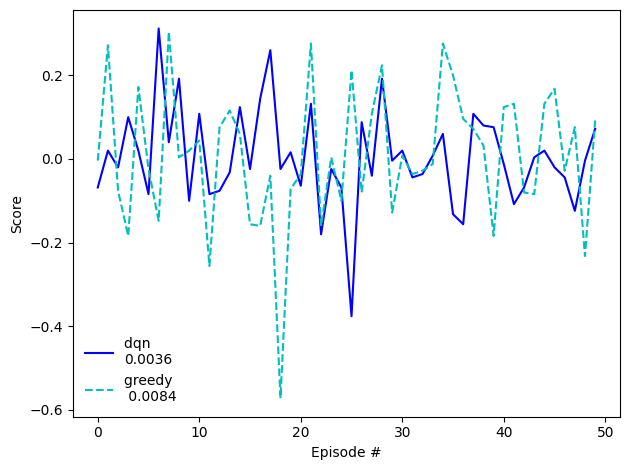

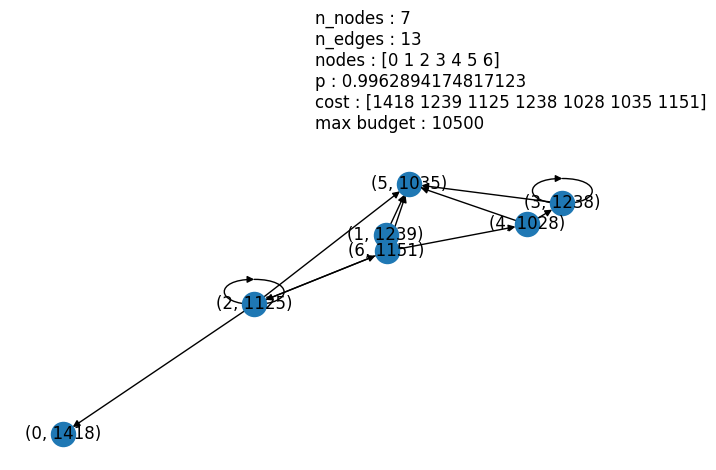

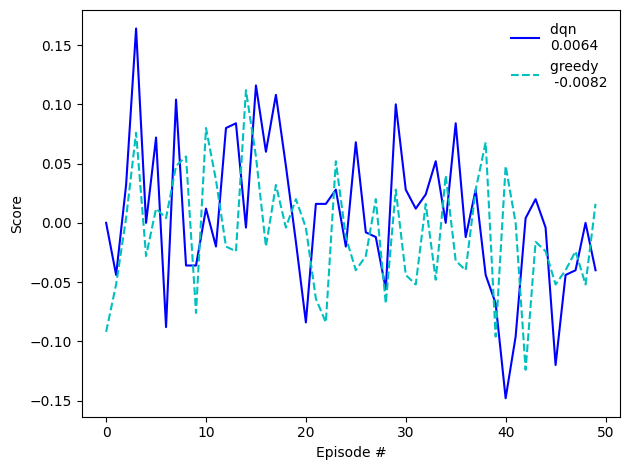

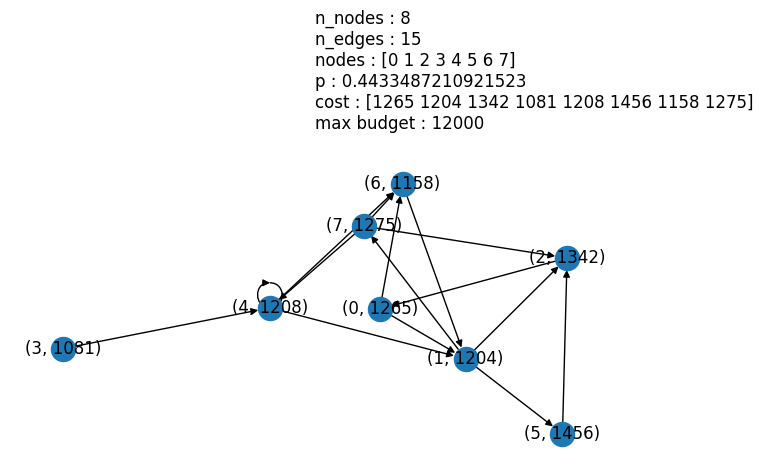

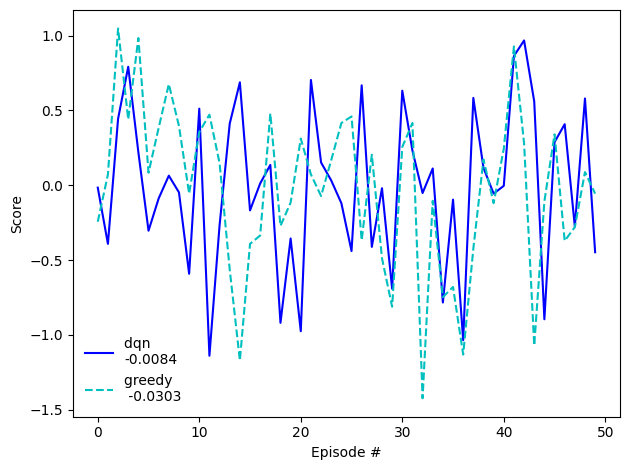

In [ ]:
for n in range(5, 9):
    maxb = 1500 * n
    cost = torch.randint(1000 , 1500, (n, ))

    n_nodes = n
    n_edges = np.random.randint(n - 1, int((n * (n - 1)) / 2))

    p = np.random.sample() 

    g = dgl.rand_graph(n_nodes, n_edges)
    env = IM(maxb, p, n_nodes, cost)
    ob = env.register(g)
    agent = Agent(state_size=env.num_nodes + 1, action_size=env.num_nodes, seed=0)

    # g = dgl.graph((src_ids, dst_ids), num_nodes=5)
    
    print("number of nodes: ", n_nodes);
    print("number of edges: ", n_edges);
    print("nodes: ", g.nodes().numpy())
    print("edges: ", g.edges())
    print("p:", p)
    print("cost: ", cost.numpy())
    print("max budget: ", maxb)

    title = "n_nodes : " + str(n_nodes) + '\n'
    title += "n_edges : " + str(n_edges) + '\n'
    title += "nodes : " + str(g.nodes().numpy()) + '\n'
    title += "p : " + str(p) + '\n'
    title += "cost : " + str(cost.numpy()) + '\n'
    title += "max budget : " + str(maxb) + '\n'
    plt_graph(g, cost, title, n + 11)
    print()
    env_greedy = copy.deepcopy(env)

    scores_dqn = dqn(env, agent, 50)
    scores_greedy = greedy(env_greedy, agent, 50)
    plt_scores(scores_dqn, scores_greedy, n + 11)
    print()
    print("------------------------------------------------------")